<a href="https://colab.research.google.com/github/anpendyal/Convolutional-Neural-Networks-in-Breast-Cancer-Identification-Research-10th-Grade-/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#give program access to google drive where the dataset is
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#get gpu info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Feb 27 00:42:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MaxPooling2D
#don't need to import classification models zoo from github because keras already has resnet50

In [ ]:
import tensorflow as tf

#resize images to 224 by 224
IMAGE_SIZE = [224, 224]

#specify paths to dataset in google drive
train_path = "/content/drive/MyDrive/SSI 20221/Train Set"
val_path = "/content/drive/MyDrive/SSI 2021/Validation Set"
test_path = "/content/drive/MyDrive/SSI 2021/Test Set"

In [ ]:
#download ResNet50 and set up model
resnet50 = ResNet50(input_shape = IMAGE_SIZE + [3], weights = "imagenet", include_top = False)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
for layer in resnet50.layers:
  layer.trainable = False

In [ ]:
from glob import glob
#training set
folders = glob("/content/drive/MyDrive/SSI 2021/Train Set/*")
len(folders)

2

In [ ]:
x = Flatten()(resnet50.output)

In [ ]:
prediction = Dense(len(folders), activation = "sigmoid")(x)

#create a model object
model = Model(inputs = resnet50.input, outputs = prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
#binary crossentropy because the model is classifying the image as having cancer or not
#optimizer as adam because it is widely used
#metrics to use in calculation (precision and recall used to calculate f1 score)
model.compile(
    loss = "binary_crossentropy",
    optimizer = "adam",
    metrics = [
               "accuracy",
                tf.keras.metrics.BinaryAccuracy(),
                tf.keras.metrics.AUC(from_logits=True),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.TruePositives(),
                tf.keras.metrics.TrueNegatives(),
                tf.keras.metrics.FalsePositives(),
                tf.keras.metrics.FalseNegatives()
               ]
)

In [ ]:
#use image data generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#image augmentation -- come back to later
#train_datagen = ImageDataGenerator(rescale = 1./255,
#                                   shear_range = 0.2,
#                                   zoom_range = 0.2,
#                                   horizontal_flip = True)

#rescale rgb values from 0-255 to 0-1
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
#same target size as initialized for images
training_set = train_datagen.flow_from_directory("/content/drive/MyDrive/SSI 2021/Train Set",
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = "categorical")

Found 21607 images belonging to 2 classes.


In [ ]:
validation_set = train_datagen.flow_from_directory("/content/drive/MyDrive/SSI 2021/Validation Set",
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = "categorical")

Found 977 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory("/content/drive/MyDrive/SSI 2021/Test Set",
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = "categorical")

Found 957 images belonging to 2 classes.


In [ ]:
from keras.callbacks import EarlyStopping

#fit the model
#early stopping for epochs

#https://keras.io/api/callbacks/early_stopping/
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/ 
#use early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)

history = model.fit(
    training_set,
    validation_data = validation_set,
    epochs = 50,
    #steps_per_epoch = len(training_set),
    #validation_steps = len(validation_set),
    callbacks = [early_stopping]
)

#print number of epochs
len(history.history['loss'])

Epoch 1/50
676/676 [==============================] - 2191s 3s/step - loss: 0.7092 - accuracy: 0.6505 - binary_accuracy: 0.6501 - auc: 0.7070 - precision: 0.6500 - recall: 0.6505 - true_positives: 14055.0000 - true_negatives: 14040.0000 - false_positives: 7567.0000 - false_negatives: 7552.0000 - val_loss: 0.5407 - val_accuracy: 0.7400 - val_binary_accuracy: 0.7410 - val_auc: 0.8099 - val_precision: 0.7425 - val_recall: 0.7380 - val_true_positives: 721.0000 - val_true_negatives: 727.0000 - val_false_positives: 250.0000 - val_false_negatives: 256.0000
Epoch 2/50
676/676 [==============================] - 77s 114ms/step - loss: 0.6171 - accuracy: 0.6984 - binary_accuracy: 0.6985 - auc: 0.7690 - precision: 0.6985 - recall: 0.6983 - true_positives: 15088.0000 - true_negatives: 15095.0000 - false_positives: 6512.0000 - false_negatives: 6519.0000 - val_loss: 0.5365 - val_accuracy: 0.7277 - val_binary_accuracy: 0.7277 - val_auc: 0.8105 - val_precision: 0.7296 - val_recall: 0.7236 - val_true_po

12

In [ ]:
#evalute model with test set
from sklearn.metrics import roc_curve, auc
model.evaluate(test_set, verbose=1)

30/30 [==============================] - 163s 6s/step - loss: 0.6257 - accuracy: 0.6949 - binary_accuracy: 0.6975 - auc: 0.7660 - precision: 0.6985 - recall: 0.6949 - true_positives: 665.0000 - true_negatives: 670.0000 - false_positives: 287.0000 - false_negatives: 292.0000


[0.6257027387619019,
 0.6948798298835754,
 0.6974921822547913,
 0.7660241723060608,
 0.6985294222831726,
 0.6948798298835754,
 665.0,
 670.0,
 287.0,
 292.0]

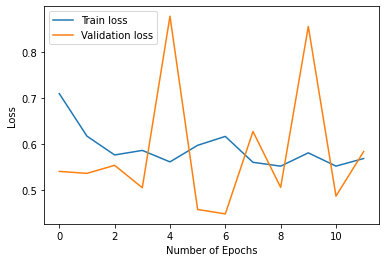

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot loss
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label = "Train loss")
plt.plot(history.history["val_loss"], label = "Validation loss")
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig("LossVal_loss")

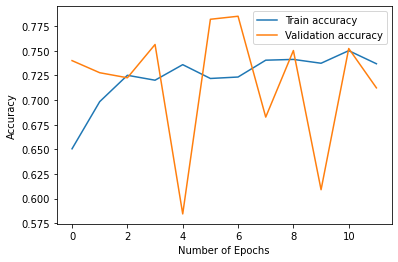

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot accuracy
plt.plot(history.history["accuracy"], label = "Train accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation accuracy")
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig("AccVal_acc")